# Load the Preprocessed dataset
** Just to avoid all the Data Cleaning everytime

## Feature Engineering

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [3]:
new_df = pd.read_csv('Pre_processed_data.csv')
Preprocessed_df = new_df.copy()
Preprocessed_df.dropna(inplace=True)
Preprocessed_df = Preprocessed_df[Preprocessed_df.Open == 1]
Preprocessed_df.drop('Open',inplace=True,axis=1)
#Preprocessed_df['CompetitionDistance'] = np.where((Preprocessed_df.IsCompetitionOpen == 1) , Preprocessed_df['CompetitionDistance'], 0)
Preprocessed_df.drop(['Promo2'],axis=1,inplace=True)
Preprocessed_df.head()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,Year,Month,DayofYear,WeekofYear,StoreType,Assortment,CompetitionDistance,hasPromo2,IsCompetitionOpen,DayofMonth
0,371,3,7374,606,0,1,2013,1,2,1,d,c,1970.0,0,0,2
1,1112,3,10797,892,0,1,2013,1,2,1,c,c,1880.0,0,0,2
2,1111,3,5097,505,0,1,2013,1,2,1,a,a,1900.0,0,0,2
3,1110,3,4126,507,0,1,2013,1,2,1,c,c,900.0,0,0,2
4,1109,3,4576,444,0,1,2013,1,2,1,c,a,3490.0,0,0,2


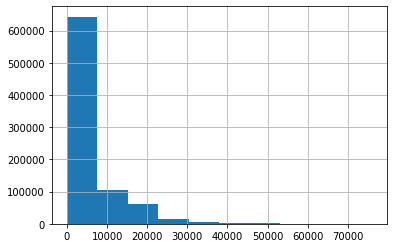

In [4]:
Preprocessed_df.CompetitionDistance.hist()

In [5]:
temp=[]
for a in Preprocessed_df.keys():
    if not pd.api.types.is_numeric_dtype(Preprocessed_df[a]):
        Preprocessed_df[a]=Preprocessed_df[a].astype('category').cat.as_ordered()
        temp.append(a)
        Preprocessed_df[a]=pd.Categorical(Preprocessed_df[a]).codes+1
        
print(temp)
len(temp)

['StoreType', 'Assortment']


2

In [6]:
Preprocessed_df.head()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,Year,Month,DayofYear,WeekofYear,StoreType,Assortment,CompetitionDistance,hasPromo2,IsCompetitionOpen,DayofMonth
0,371,3,7374,606,0,1,2013,1,2,1,4,3,1970.0,0,0,2
1,1112,3,10797,892,0,1,2013,1,2,1,3,3,1880.0,0,0,2
2,1111,3,5097,505,0,1,2013,1,2,1,1,1,1900.0,0,0,2
3,1110,3,4126,507,0,1,2013,1,2,1,3,3,900.0,0,0,2
4,1109,3,4576,444,0,1,2013,1,2,1,3,1,3490.0,0,0,2


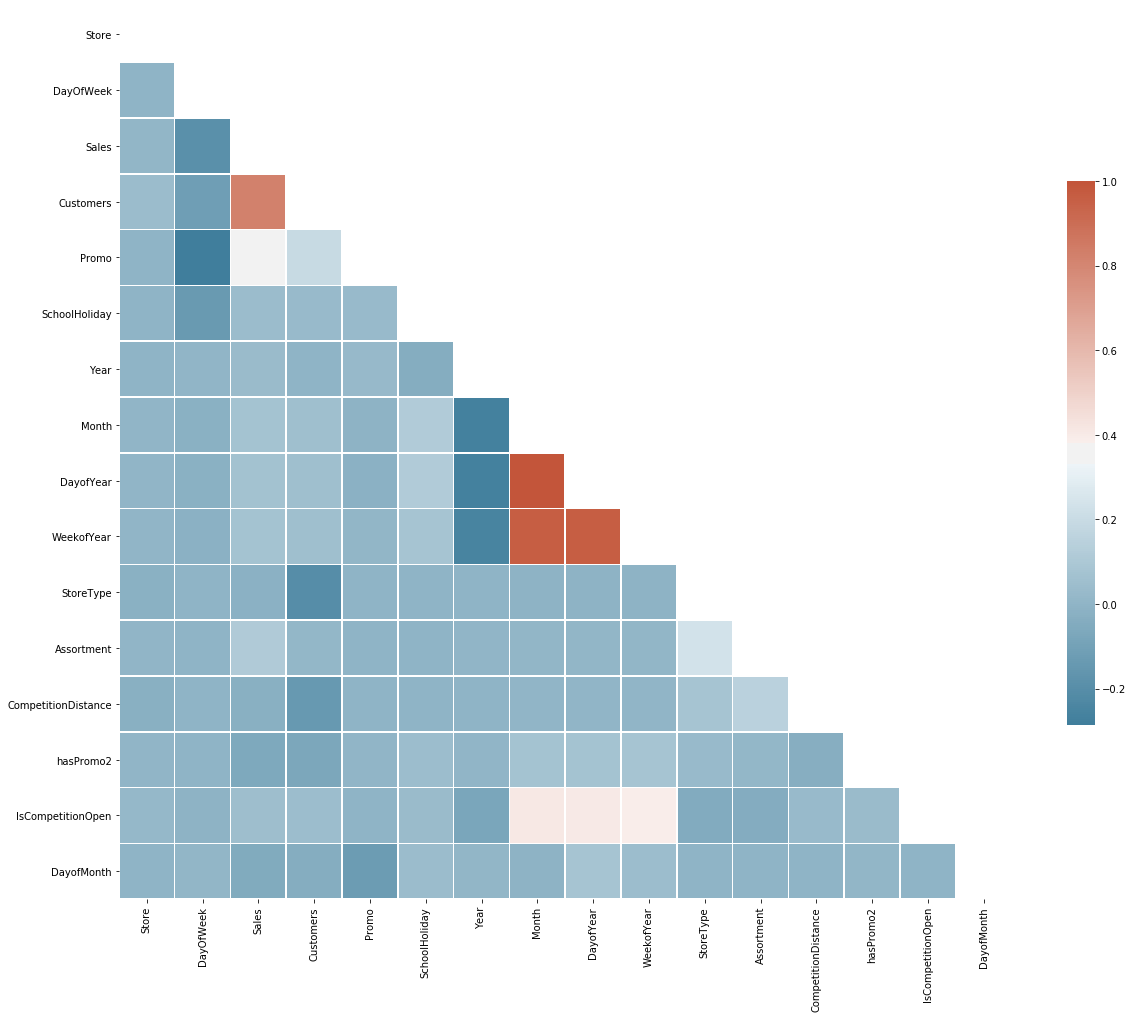

In [9]:
corr=Preprocessed_df.corr()
plt.figure(figsize=(20,20));
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [10]:
print(Preprocessed_df.isna().sum())
len(Preprocessed_df)

Store                  0
DayOfWeek              0
Sales                  0
Customers              0
Promo                  0
SchoolHoliday          0
Year                   0
Month                  0
DayofYear              0
WeekofYear             0
StoreType              0
Assortment             0
CompetitionDistance    0
hasPromo2              0
IsCompetitionOpen      0
DayofMonth             0
dtype: int64


837708

In [11]:
x = Preprocessed_df.drop(['Store','WeekofYear','Sales','Customers','Year'],axis=1)
y = Preprocessed_df.Sales

In [12]:
from sklearn.model_selection import train_test_split as tts
x_train,x_val,y_train,y_val = tts(x,y,test_size=0.2)

In [33]:
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
def mspe(y_actual,y_predict):
    y_act = y_actual[y_actual>0]
    y_pred = y_predict[y_actual>0]
    #y_act[y_act==0] = y_act.mean()

    loss = (np.sqrt(np.mean(np.square((y_act - y_pred) / y_act))))
    return loss
def get_metrics(y_act,y_pred):
    metrics = {}
    metrics['Mean Squared Error'] = mse(y_act,y_pred)
    metrics['Mean Absolute Error'] = mae(y_act,y_pred)
    metrics['Mean Squared Percentage Error'] = mspe(y_act,y_pred)
    return metrics

In [23]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv_score = cross_val_score(rfr,x_train,y_train,cv=cv,
                           verbose = 1,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 13.1min finished


In [24]:
rfr = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=100000)
rfr.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=100000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#### Random Forest Regressor Validation

## Hyper-Parameter tuning

In [29]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 200, 20),
           "max_depth": [3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [20000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=100,
                              cv=3,
                              verbose=2)

# Fit the RandomizedSearchCV model
rs_model.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=170, min_samples_split=2, min_samples_leaf=9, max_samples=20000, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=170, min_samples_split=2, min_samples_leaf=9, max_samples=20000, max_features=sqrt, max_depth=5, total=   3.8s
[CV] n_estimators=170, min_samples_split=2, min_samples_leaf=9, max_samples=20000, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV]  n_estimators=170, min_samples_split=2, min_samples_leaf=9, max_samples=20000, max_features=sqrt, max_depth=5, total=   2.4s
[CV] n_estimators=170, min_samples_split=2, min_samples_leaf=9, max_samples=20000, max_features=sqrt, max_depth=5 
[CV]  n_estimators=170, min_samples_split=2, min_samples_leaf=9, max_samples=20000, max_features=sqrt, max_depth=5, total=   2.4s
[CV] n_estimators=130, min_samples_split=18, min_samples_leaf=3, max_samples=20000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=130, min_samples_split=18, min_samples_leaf=3, max_samples=20000, max_features=sqrt, max_depth=10, total=   3.0s
[CV] n_estimators=130, min_samples_split=18, min_samples_leaf=3, max_samples=20000, max_features=sqrt, max_depth=10 
[CV]  n_estimators=130, min_samples_split=18, min_samples_leaf=3, max_samples=20000, max_features=sqrt, max_depth=10, total=   2.9s
[CV] n_estimators=130, min_samples_split=18, min_samples_leaf=3, max_samples=20000, max_features=sqrt, max_depth=10 
[CV]  n_es

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  8.6min finished


CPU times: user 8min 1s, sys: 23.4 s, total: 8min 25s
Wall time: 8min 37s


### THe best parameters for 20k sample size are as follows

In [31]:
rs_model.best_params_

{'max_depth': 10,
 'max_features': 'auto',
 'max_samples': 20000,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 30}

In [34]:
y_pred = rs_model.predict(x_train)
get_metrics(y_train,y_pred)

{'Mean Absolute Error': 1760.3502865749617,
 'Mean Squared Error': 5806766.805154214,
 'Mean Squared Percentage Error': 0.44750409442064426}

In [35]:
y_pred = rs_model.predict(x_val)
get_metrics(y_val,y_pred)

{'Mean Absolute Error': 1766.9434137032986,
 'Mean Squared Error': 5880482.591579018,
 'Mean Squared Percentage Error': 0.430154187892323}

### Inserting best parameters into the model

In [36]:
rfr_modified = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=300000,
                              max_depth= 10,
                              max_features= 'auto',
                              min_samples_leaf= 1,
                              min_samples_split= 8,
                              n_estimators= 30)
rfr_modified.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=300000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [38]:
y_pred = rfr_modified.predict(x_train)
get_metrics(y_train,y_pred)

{'Mean Absolute Error': 1728.7407184557067,
 'Mean Squared Error': 5615826.126705838,
 'Mean Squared Percentage Error': 0.4435827386322419}

In [39]:
y_pred = rfr_modified.predict(x_val)
get_metrics(y_val,y_pred)

{'Mean Absolute Error': 1739.5163108459712,
 'Mean Squared Error': 5723848.565043277,
 'Mean Squared Percentage Error': 0.4258054249898184}

### Try XGBoost regressor

In [41]:
import xgboost
regressor = xgboost.XGBRegressor(verbose = 1)

In [42]:
regressor.fit(x_train,y_train)

[00:47:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbose=1, verbosity=1)

In [44]:
y_pred = regressor.predict(x_train)
get_metrics(y_train,y_pred)

{'Mean Absolute Error': 1818.5666576376198,
 'Mean Squared Error': 6270714.770449938,
 'Mean Squared Percentage Error': 0.48416180687280247}

In [48]:
y_pred = regressor.predict(x_val)
get_metrics(y_val,y_pred)

{'Mean Absolute Error': 1821.6971248443604,
 'Mean Squared Error': 6310267.145302243,
 'Mean Squared Percentage Error': 0.45324105387957453}

### Models Evaluation:

In [57]:
models = {'Random_forest': rfr, 'Tuned Random Forest' : rfr_modified, 'XGBoost': regressor}
train_metrics = {}
validation_metrics = {}
for key,model in models.items():
    y_pred = model.predict(x_train)
    y_val_pred = model.predict(x_val)
    train_metrics[key] = get_metrics(y_train,y_pred)
    validation_metrics[key] = get_metrics(y_val,y_val_pred)

In [61]:
for key in train_metrics.keys():
    print(f'Metrics for {key} model:\n')
    print(f'Training metrics : \n')
    print(train_metrics[key])
    print(f'\n')
    print(f'Validation metrics : \n')
    print(validation_metrics[key])
    print(f'\n\n')

Metrics for Random_forest model:

Training metrics : 

{'Mean Squared Error': 1957657.3049824145, 'Mean Absolute Error': 899.2803573037626, 'Mean Squared Percentage Error': 0.2619065233543824}


Validation metrics : 

{'Mean Squared Error': 2594947.316954761, 'Mean Absolute Error': 1037.3568934466182, 'Mean Squared Percentage Error': 0.26064463361655377}



Metrics for Tuned Random Forest model:

Training metrics : 

{'Mean Squared Error': 5615826.126705838, 'Mean Absolute Error': 1728.7407184557067, 'Mean Squared Percentage Error': 0.4435827386322419}


Validation metrics : 

{'Mean Squared Error': 5723848.565043277, 'Mean Absolute Error': 1739.5163108459712, 'Mean Squared Percentage Error': 0.4258054249898184}



Metrics for XGBoost model:

Training metrics : 

{'Mean Squared Error': 6270714.770449938, 'Mean Absolute Error': 1818.5666576376198, 'Mean Squared Percentage Error': 0.48416180687280247}


Validation metrics : 

{'Mean Squared Error': 6310267.145302243, 'Mean Absolute Error

#### Random Forest Regressor has the lowest Mean squared percentage error and that is chosen as the final model

In [31]:
import pickle
from pathlib import Path
path = str(Path(os.getcwd()).parent)
fileloc = os.path.join(path,'Delivery and Acceptance','randomforest.pkl')
pickle.dump(rfr, open(fileloc, 'wb'))

## Prediction

In [ ]:
import datetime
def predict(input_dict,model):
    predict_dict = {}
    date = datetime.datetime.strptime(input_dict['Date'], '%Y-%m-%d')
    if input_dict['State_holiday'] != 0 or date.weekday()==6:
        return 0
    else:
        predict_dict['Assortment']=[cat_dict[input_dict['Assortment']]]
        predict_dict['StoreType']=[cat_dict[input_dict['StoreType']]]
        predict_dict['DayofMonth'] = [date.day]
        predict_dict['Month'] = [date.month]
        predict_dict['DayOfWeek'] = [date.weekday()+1]
        predict_dict['SchoolHoliday'] = [input_dict['School_holiday']]
        predict_dict['Promo'] = [input_dict['Promo1']]
        predict_dict['hasPromo2'] = [input_dict['Promo2']]
        predict_dict['IsCompetitionOpen'] = input_dict['Competition_exists']
        predict_dict['CompetitionDistance']=[input_dict['CompetitionDistance']]
        predict_dict['DayofYear'] = [(date - datetime.datetime(date.year, 1, 1)).days + 1]
        df = pd.DataFrame.from_dict(predict_dict)
        return model.predict(df).astype(int)[0]
    

In [ ]:
## Sample prediction inputs
Input_dict = {
'Date' : '2015-12-18',
'Assortment' : 'a',
'StoreType' : 'b',
'Promo1' : 1,
'Promo2' : 0,
'State_holiday' : 0,
'School_holiday' : 1,
'Competition_exists' : 1,
'CompetitionDistance' : 4000
}
cat_dict = {'a':1,'b':2,'c':3,'d':4}

In [ ]:
predict(Input_dict,loaded_model)

9097